# Data Collection

## Data Scraping

For scraping the Wikipedia data we used pywikibot, which is a Python library specifically built for this.
1. Loop through subcategories from a base category "Video games by year"
2. Filter the selected subcategories to exclude irrelevant pages like "Video game franchises by year of introduction"
3. Loop through the articles in each subcategory
4. Save the article text, category, title and URL as JSON nodes, one JSON-file per article

In [ ]:
import os
import json
import pywikibot

def get_subcategories_from_category(category_name):
    site = pywikibot.Site('en', 'wikipedia')
    cat = pywikibot.Category(site, category_name)
    pages = list(cat.subcategories())
    return [page.title() for page in pages]

def get_games_from_category(category_name):
    site = pywikibot.Site('en', 'wikipedia')
    cat = pywikibot.Category(site, category_name)
    pages = list(cat.articles())
    return pages

def save_to_json(page, subcategory):
    data = {
        "text": page.text,
        "category": subcategory,
        "title": page.title(),
        "url": page.full_url(),
    }

    directory = os.path.join('./data', subcategory.split(':')[-1])
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, page.title().replace('/', '_') + '.json')
    with open(filepath, 'w', encoding='utf-8') as json_file:
        json.dump(data, json_file, ensure_ascii=False, indent=4)

# Start with the base category
category_name = 'Category:Video games by year'
game_categories = get_subcategories_from_category(category_name)

# Go through each sub-category to get the game pages
for game_category in game_categories:
    # Make sure we only look at the relevant categories (avoiding 'by decade' etc.)
    if 'video games' in game_category.lower():
        game_pages = get_games_from_category(game_category)
        for page in game_pages:
            save_to_json(page, game_category.split(':')[-1])

## Data processing 

Now we processed the downloaded data for easier usage with sentiment and network analysis.

1. Loop through each downloaded file in each subfolder
2. Append each page name to a new row in a CSV file

In [ ]:
import os
import json
import csv
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def get_all_page_names_from_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
    return data['title']

base_directory = 'project/data'
all_page_names = []

# Get all page names (multithreading is used for better performance)
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_all_page_names_from_json, os.path.join(base_directory, subcategory, json_file))
                for subcategory in os.listdir(base_directory)
                for json_file in os.listdir(os.path.join(base_directory, subcategory))]
    
    for future in tqdm(futures, desc="Fetching Page Names", unit="files"):
        all_page_names.append(future.result())

# Save all page names to CSV
with open('all_page_names.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Page Names'])
    for page_name in all_page_names:
        writer.writerow([page_name])


3. Iterate through all article JSONs based on the file name list in the CSV file
4. Extract and filter out all outlinks (other articles) in the JSON
5. Extract and insert categories as a subnode in the JSON
6. Find the country of development, extract the name and insert it as a subnode in the JSON

In [ ]:
import os
import json
import re
import csv
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def extract_outlinks(text):
    links = re.findall(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', text)
    return [link.split('#')[0] for link in links]

def extract_categories(text):
    return re.findall(r'\[\[Category:(.*?)\]\]', text)

def get_all_page_names_from_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
    return data['title']

# Generic function to update JSON files
def update_json(filepath, update_func, *args):
    with open(filepath, 'r', encoding='utf-8') as json_file:
        data = json.load(json_file)
    
    update_func(data, *args)  # Call the provided update function
    
    with open(filepath, 'w', encoding='utf-8') as json_file:
        json.dump(data, json_file, ensure_ascii=False, indent=4)


def update_json_with_country_of_development(data):
    # Extract development based on the categories
    countries_of_development = []
    for category in data.get('categories', []):
        match = re.match(r'Video games developed in (.+)', category)
        if match:
            country = match.group(1)
            countries_of_development.append(country)
    
    # If no countries are found, set to ["other"]
    data['country of development'] = countries_of_development if countries_of_development else ["other"]
     
# Specific update methods
def filter_outlinks(data, all_page_names):
    data['outpages'] = [link for link in extract_outlinks(data['text']) if link in all_page_names]

def add_categories(data):
    data['categories'] = extract_categories(data['text'])

def load_csv_as_list(filepath):
    with open(filepath, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        # Skip the header row if the CSV has one
        next(reader, None)
        return list(reader)

base_directory = 'project/data'

# Update JSON files with filtered outlinks and categories
json_files = [os.path.join(base_directory, subcategory, json_file)
                for subcategory in os.listdir(base_directory)
                for json_file in os.listdir(os.path.join(base_directory, subcategory))]

with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(lambda x: update_json(x, filter_outlinks, all_page_names), json_files), 
              total=len(json_files), desc="Filtering Outlinks", unit="files"))
    list(tqdm(executor.map(lambda x: update_json(x, add_categories), json_files), 
              total=len(json_files), desc="Adding Categories", unit="files"))
    list(tqdm(executor.map(lambda x: update_json(x, update_json_with_country_of_development), json_files), 
        total=len(json_files), desc="Adding country of development", unit="files"))

### Extracting sections

For extracting the required sections, we used the library mwparserfromhell, which is targeted for MediaWiki-style wikis, such as Wikipedia.

1. Loop through all articles
2. Iterate through article text to find headings
3. Save the section to a dictionary node
4. Remove references and other formatting
5. Save all sections per article as a JSON file 

In [ ]:
import os
import json
import mwparserfromhell

def parse_wiki_text_to_sections(wiki_text):
    # Parse the text with mwparserfromhell
    wikicode = mwparserfromhell.parse(wiki_text, skip_style_tags=True)
    
    sections_dict = {}
    current_section = 'introduction'
    sections_dict[current_section] = '' # Initialize the intro section

    # Iterate through the parsed wiki code
    for node in wikicode.nodes:
        if isinstance(node, mwparserfromhell.nodes.heading.Heading):
            # When we find a heading, set the current section to the heading's title
            current_section = str(node.title).strip().lower()
            sections_dict[current_section] = ''
        else:
            # Otherwise, append the text of this node to the current section
            sections_dict[current_section] += str(node)

    # Clean up text for each section
    for section, text in sections_dict.items():
        # Remove references and other unwanted parts
        text = mwparserfromhell.parse(text).strip_code()
        sections_dict[section] = text

    return sections_dict

def load_json_data_to_dict(base_directory):
    all_data = {}  
    for subdir, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.json'):
                filepath = os.path.join(subdir, file)
                with open(filepath, 'r', encoding='utf-8') as json_file:
                    data = json.load(json_file)
                    data["text"] = parse_wiki_text_to_sections(data["text"])
                    all_data[data['title']] = data
    return all_data

base_directory = './data'
data_file = 'game_data.json'

if os.path.exists(data_file):
    with open(data_file) as f:
        json_data_dict = json.load(f)
else:
    json_data_dict = load_json_data_to_dict(base_directory)
    with open('game_data.json', 'w', encoding='utf-8') as json_file:
        json.dump(json_data_dict, json_file, ensure_ascii=False, indent=4)

# Sentiment analysis

## Helper functions

In [ ]:
import json

# Load the JSON file containing all sections of all articles.
data_file = '../game_data.json'

with open(data_file, encoding="utf-8") as f:
    game_data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram with specified parameters
def create_histogram(data, title, xlabel, ylabel, color='tab:blue', figuresize=(10, 6)):
    labels = list(data.keys())
    values = list(data.values())

    n_bars = len(labels)
    figure_width = max(labels) - min(labels)

    bar_width = figure_width / (1.5 * n_bars)

    plt.figure(figsize=figuresize)
    plt.bar(labels, values, color=color, edgecolor='black', width=bar_width)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import json

analyzer = SentimentIntensityAnalyzer()
# Function to get sentiment scores
weight_neg = 0.7
weight_compound = 1-  weight_neg 

def normalize_score(score, old_min, old_max, new_min, new_max):
    return ((score - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

# Our "violence" score algorithm
def get_violence_score(neg_score, pos_score, weight_neg, weight_compound):
    # Normalize 'neg' score from [0, 1] to [-1, 1]
    normalized_neg_score = normalize_score(neg_score, 0, 0.35, 0, 1)
    normalized_pos_score = normalize_score(pos_score, 0, 0.3, 0, 1)
    
    # Calculate the weighted score
    violence_score = normalized_neg_score * weight_neg - normalized_pos_score * weight_compound
    
    return violence_score

# Get Vader's sentiment scores and insert them to our violence store method
def get_sentiment_scores(data, subsections = ["gameplay"]):
    sentiment_scores = {}
    for title, content in data.items():
        text = "\n".join([content['text'][subsection] for subsection in subsections if subsection in content["text"]])
        sentiment = analyzer.polarity_scores(text)
        sentiment["violence"] = get_violence_score(sentiment["neg"], sentiment["pos"], weight_neg, weight_compound)
        sentiment_scores[title] = sentiment
    return sentiment_scores

# Create a histogram of sentiment scores
def create_sentiment_histograms(sentiment_data, sentiments_to_plot=None):
    # Default to all sentiment types if none are specified
    if sentiments_to_plot is None:
        sentiments_to_plot = ['pos', 'neu', 'neg', 'compound']

    # Determine the number of plots
    num_plots = len(sentiments_to_plot)
    cols = 2  # We prefer a 2-column layout
    rows = (num_plots + 1) // cols  # Calculate rows needed

    # Set up the figure for multiple subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows > 1:
        axes = axes.flatten()  # Flatten if we have more than one row
    else:
        axes = [axes]  # Wrap in list if only one row (i.e., 1 or 2 plots)

    fig.suptitle('Sentiment Analysis Histograms')

    # Plotting each requested sentiment
    for i, sentiment in enumerate(sentiments_to_plot):
        scores = [details[sentiment] for details in sentiment_data.values()]
        ax = axes[i]
        ax.hist(scores, bins=200, color='tab:blue', edgecolor='black')
        ax.set_title(f'{sentiment.capitalize()} Sentiment Score')
        ax.set_xlabel('Sentiment Score')
        ax.set_ylabel('Number of Games')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def print_top_bottom_sentiment_games(sentiment_scores, key='compound', n = 10):
    # Sorting the games based on the compound sentiment score
    sorted_games = sorted(sentiment_scores.items(), key=lambda x: x[1][key])
    
    # Print the 10 most negative games
    print(f"{n} Most Negative Games in terms of {key} sentiment:")
    for game, score in sorted_games[:n]:
        print(f"{game}: {score}")

    print("\n") # Newline

    # Print the 10 most positive games
    print(f"{n} Most Positive Games in terms of {key} sentiment:")
    for game, score in sorted_games[-n:]:
        print(f"{game}: {score}")

# Check if the length of a subsection is within the specified range.
def is_subsection_length_valid(data, subsections, min_length, max_length):
    subsection_text = ""
    for subsection in subsections:
        subsection_text += data.get('text', {}).get(subsection, "") + "\n"
    word_count = len(subsection_text.split())
    return min_length <= word_count <= max_length

# Count the number of entries in the game_data dictionary that have a specified subsection with a string length within the given range.
def count_long_subsections(game_data, subsection='gameplay', min_length=0, max_length=float('inf')):
    return sum(is_subsection_length_valid(data, subsection, min_length, max_length) for _, data in game_data.items())

# Create a dictionary with only the entries from game_data that have a specified subsection with a string length within the given range.
def filter_entries_by_length(game_data, subsections=['gameplay'], min_length=0, max_length=float('inf')):
    return {game: data for game, data in game_data.items() if is_subsection_length_valid(data, subsections, min_length, max_length)}

# Save specified data as a JSON file
def get_or_create_value(function_to_apply, file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the value from the file
        with open(file_path, 'r') as file:
            value = json.load(file)
    else:
        # Call the function to create the value
        value = function_to_apply()
        # Save the value to the file
        with open(file_path, 'w') as file:
            json.dump(value, file)
    
    return value

## Creating the sentiment dictionary

Creates a sentiment dictionary by looping through the predefined sections in all files, then calculating the violence score in that section.

In [ ]:
# Constraints for filtering entries by length
constrains = {
    "min_length": 100,
    "max_length": 10000
}

# List of subsections to filter from game_data
subsections = ['gameplay', 'plot', 'story', 'synopsis', 'plot and gameplay', 'plot and gameplay']

# Filtering entries by length based on constraints
filtered_by_length = filter_entries_by_length(game_data, subsections=subsections, **constrains)

# Getting sentiment scores for filtered entries and storing them in a JSON file
sentiment_filtered_by_length = get_or_create_value(
    lambda: get_sentiment_scores(filtered_by_length, subsections),
    file_path="filtered_gameplay_sentiment.json"
)

# Extracting violence scores for each game from the sentiment data
violence = [sentiment["violence"] for game, sentiment in sentiment_filtered_by_length.items()]

# Normalizing violence scores between 0 and 1
for game, sentiment in sentiment_filtered_by_length.items():
    sentiment["violence"] = normalize_score(sentiment["violence"], min(violence), max(violence), 0, 1)

# Creating histograms for sentiment analysis including violence
create_sentiment_histograms(
    sentiment_data=sentiment_filtered_by_length,
    sentiments_to_plot=['pos', 'neu', 'neg', 'compound', "violence"]
)

# Adding VADER sentiment analysis results for gameplay to game_data
game_data_with_vader_sentiment_on_gameplay = get_or_create_value(
    lambda: {
        game: {**data, 'sentiment': sentiment_filtered_by_length[game]}
        for game, data in filtered_by_length.items()
    },
    "game_data_with_vader_sentiment.json"
)

## Testing different scores

Compares different scoring algorithms with visual graphs to find out which one is the best.

In [ ]:
import pandas as pd

def compare_violence_scores(data, most_violent, least_violent):
    # Initialize dictionaries to hold the scores for the most and least violent games
    most_violences = {'neg': [], 'neu': [], 'pos': [], 'compound': [], "violence": []}
    least_violences = {'neg': [], 'neu': [], 'pos': [], 'compound': [], "violence": []}
    
    # Helper function to calculate average of a list
    def average(lst):
        return sum(lst) / len(lst) if lst else 0
    
    # Extract scores for each game in the most and least violent games lists
    for game in most_violent:
        if game in data:
            most_violences['neg'].append(data[game]['neg'])
            most_violences['neu'].append(data[game]['neu'])
            most_violences['pos'].append(data[game]['pos'])
            most_violences['compound'].append(data[game]['compound'])
            most_violences['violence'].append(data[game]['violence'])
    
    for game in least_violent:
        if game in data:
            least_violences['neg'].append(data[game]['neg'])
            least_violences['neu'].append(data[game]['neu'])
            least_violences['pos'].append(data[game]['pos'])
            least_violences['compound'].append(data[game]['compound'])
            least_violences['violence'].append(data[game]['violence'])
    
    # Calculate averages for both groups
    averages = {
        'Score': ['neg', 'neu', 'pos', 'compound', "violence"],
        'Average Most Violent': [
            average(most_violences['neg']),
            average(most_violences['neu']),
            average(most_violences['pos']),
            average(most_violences['compound']),
            average(most_violences['violence'])
        ],
        'Average Least Violent': [
            average(least_violences['neg']),
            average(least_violences['neu']),
            average(least_violences['pos']),
            average(least_violences['compound']),
            average(least_violences['violence'])
        ]
    }
    
    # Create a DataFrame to display the table
    df = pd.DataFrame(averages)
    
    # Calculate and add a column for the difference between the most and least violent scores
    df['Difference (Most - Least)'] = df['Average Most Violent'] - df['Average Least Violent']
    
    return df

most_violent = ["Doom (2016 video game)", "Grand Theft Auto V", "Mortal Kombat (1992 video game)", "God of War (2005 video game)", "Manhunt (video game)", "Gears of War (video game)", "Call of Duty 4: Modern Warfare", "Dead Space (2008 video game)", "Resident Evil (1996 video game)", "Hotline Miami"]
least_violent = ["Animal Crossing: New Horizons", "Stardew Valley", "The Sims 4", "Minecraft", "Tetris", "Monument Valley (video game)", "Super Mario Odyssey", "Journey (2012 video game)", "Katamari Damacy", "Fez (video game)"]
compare_violence_scores(sentiment_filtered_by_length, most_violent, least_violent)

## Analyzing sentiment

In [ ]:
# Extract the production year from the category.
import re
for game, data in game_data.items():
    match = re.match(r'^\d+', data["category"])
    if match:
        data["year"] = int(match.group())
    else:
        raise RuntimeError()
    data.pop("category")

## Sentiment per Year

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from collections import defaultdict
import numpy as np

# Calculate the average and standard deviation of specified sentiment scores per year from a dataset
def calculate_sentiment_statistics(game_data: dict, sentiment_key: str):
    sentiment_sum_per_year = defaultdict(float)
    count_per_year = defaultdict(int)

    # Sum sentiment scores and count entries for each year
    for game in game_data.values():
        try:
            year = game['year']
            sentiment_score = game["sentiment"][sentiment_key]
            sentiment_sum_per_year[year] += sentiment_score
            count_per_year[year] += 1
        except KeyError as e:
            print(f"Missing key in data: {e}")

    # Calculate the average sentiment score for each year
    average_sentiment_per_year = {year: sentiment_sum_per_year[year] / count_per_year[year]
                                  for year in sentiment_sum_per_year}

    # Calculate standard deviation for each year
    std_dev_per_year = {year: np.std([game["sentiment"][sentiment_key] 
                                      for game in game_data.values() if game['year'] == year])
                        for year in count_per_year}

    return average_sentiment_per_year, std_dev_per_year

def plot_violence_statistics(average_violence, std_deviation):
    # Sort the data by year
    sorted_years = sorted(average_violence.keys())
    average_violences = [average_violence[year] for year in sorted_years]
    std_devs = [std_deviation[year] for year in sorted_years]

    # Plotting with enhancements
    plt.figure(figsize=(12, 6))

    # Plot average violence scores with error bars
    plt.errorbar(sorted_years, average_violences, yerr=std_devs, fmt='-o',
                 label='Average with Std Dev', color='blue')

    # Fit and plot a trend line
    z = np.polyfit(sorted_years, average_violences, 1)
    p = np.poly1d(z)
    plt.plot(sorted_years, p(sorted_years), "r--", label='Trend Line')

    # Labels and title
    plt.title('Violence Scores Over the Years with Trend and Variability')
    plt.xlabel('Year')
    plt.ylabel('Violence Score')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


average_violence, std_deviation = calculate_sentiment_statistics(game_data, "violence")
plot_violence_statistics(average_violence, std_deviation)

## Sentiment per country

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Extract relevant data
country_violence_data = defaultdict(list)
for game, details in game_data.items():
    # We assume 'violence' scores are within a 'sentiment' sub-dictionary
    violence_score = details["sentiment"]["violence"]
    for country in details["country of development"]:
        country_violence_data[country].append(violence_score)

# Count the number of games per country
game_counts = Counter({country: len(scores) for country, scores in country_violence_data.items()})

# Calculate average violence score for each country with at least 100 games or is Denmark
average_violence_scores = {}
for country, violence_scores in country_violence_data.items():
    if (game_counts[country] >= 100 or country == "Denmark") and country != "other":
        average_violence_scores[country] = sum(violence_scores) / len(violence_scores)

# Add all other countries to 'Others'
other_violence_scores = []
for country, violence_scores in country_violence_data.items():
    if (game_counts[country] < 100 and country != "Denmark") or "other":
        other_violence_scores.extend(violence_scores)
if other_violence_scores:
    average_violence_scores["Others"] = sum(other_violence_scores) / len(other_violence_scores)

# Calculate overall average violence score
all_scores = [score for scores in country_violence_data.values() for score in scores]
overall_average_violence = sum(all_scores) / len(all_scores)

# Plot the average violence scores
countries = sorted(list(average_violence_scores.keys()), key= lambda x: average_violence_scores[x]) 
averages = [average_violence_scores[country] for country in countries]

plt.figure(figsize=(10, 5))
plt.bar(countries, averages)
plt.xlabel('Country of Development')
plt.ylabel('Average Violence Score')
plt.title('Average Violence Score by Country of Development')
plt.xticks(rotation=90)  # Rotate country names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Add a line for the overall average violence level
plt.axhline(y=overall_average_violence, color='r', linestyle='-', label=f'Overall Average ({overall_average_violence:.2f})')
plt.legend()
plt.show()

# Network Analysis

## Creating the graph

Process a bit more the data so the attributes are more easily extracted and added as node atributes.

In [ ]:
# Get year property
selected_attributes = ['outpages', 'year', 'country of development', 'sentiment', 'genres']
categorie = []
new_game_data = dict()
for g in game_data:
    new_game_data[g] = dict()
    new_game_data[g]['outpages'] = [el for el in game_data[g]['outpages'] if el in game_data.keys()]
    new_game_data[g]['year'] = int(game_data[g]['categorie'].split(' ')[0])
    new_game_data[g]['country of development'] = game_data[g]['country of development']
    new_game_data[g]['sentiment'] = game_data[g]['sentiment']
    new_game_data[g]['genres'] = [el for el in game_data[g]['categories'] if el in video_game_genres]
    

Creating the graph from the treated data.

In [ ]:
import networkx as nx

def create_directed_graph(data, selected_attributes = []):
    # Create a directed graph
    G = nx.DiGraph()
    # Iterate over dictionary items
    for node, properties in data.items():
        selected_attributes_dict = dict()
        for att in selected_attributes:
            selected_attributes_dict[att] = properties[att]
        # Add the node to the graph
        G.add_node(node, **selected_attributes_dict)
        # Add edges from this node to each node in 'outpages'
        for outpage in properties.get('outpages', []):
            G.add_edge(node, outpage)

    return G
DIRECTED_G = create_directed_graph(new_game_data, selected_attributes)
UNDIRECTED_G = DIRECTED_G.copy().to_undirected()

## Basic analysis

In [ ]:
print(f"Nodes: {DIRECTED_G.number_of_nodes()}")
print(f"Directed Edges: {DIRECTED_G.number_of_edges()}")
print(f"Undirected Edges: {UNDIRECTED_G.number_of_edges()}")

Nodes: 16261
Directed Edges: 28724
Undirected Edges: 24263


## Degree analysis

We calculate which nodes are the most connected: incoming and outgoing.

In [ ]:
most_connected_out = sorted(dict(DIRECTED_G.out_degree).items(), key=lambda x:x[1], reverse=True)[0:10]
most_connected_out

[('Pac-Man', 47),
 ('Rare Replay', 31),
 ('Donkey Kong Country', 29),
 ('Street Fighter II', 28),
 ('Pac-Man 99', 26),
 ('Donkey Kong (arcade game)', 26),
 ('The Legend of Zelda: Breath of the Wild', 25),
 ('Super Mario Kart', 23),
 ('Knight Lore', 23),
 ("Luigi's Mansion", 23)]

In [ ]:
most_connected_in = sorted(dict(DIRECTED_G.in_degree).items(), key=lambda x:x[1], reverse=True)[0:10]
most_connected_in

[('Pac-Man', 172),
 ('Tetris', 126),
 ('Super Mario Bros.', 111),
 ('Super Smash Bros. Ultimate', 110),
 ('Street Fighter II', 104),
 ('Myst', 97),
 ('Minecraft', 86),
 ('Space Invaders', 84),
 ('Final Fantasy VII', 84),
 ('Super Mario 64', 83)]

We see those nodes combined with the sentiment data.

In [ ]:
df = pd.DataFrame(columns=["In-Name", "In-Connections", "In-Violence", "Out-Name", "Out-Connections" ,"Out-Violence"])

for i in range(10):
    df.loc[len(df)] = {
        "In-Name": most_connected_in[i][0],
        "In-Connections": most_connected_in[i][1],
        "In-Violence": sentiment[most_connected_in[i][0]]["violence"],
        "Out-Name": most_connected_out[i][0],
        "Out-Connections": most_connected_out[i][1],
        "Out-Violence": sentiment[most_connected_out[i][0]]["violence"],
    }
df

,In-Name,In-Connections,In-Violence,Out-Name,Out-Connections,Out-Violence
0,Pac-Man,172,0.297727,Pac-Man,47,0.297727
1,Tetris,126,0.280682,Rare Replay,31,0.264773
2,Super Mario Bros.,111,0.461364,Donkey Kong Country,29,0.410227
3,Super Smash Bros. Ultimate,110,0.400000,Street Fighter II,28,0.357955
4,Street Fighter II,104,0.357955,Pac-Man 99,26,0.319318
5,Myst,97,0.363636,Donkey Kong (arcade game),26,0.328409
6,Minecraft,86,0.473864,The Legend of Zelda: Breath of the Wild,25,0.368182
7,Space Invaders,84,0.505682,Super Mario Kart,23,0.351136
8,Final Fantasy VII,84,0.513636,Knight Lore,23,0.517045
9,Super Mario 64,83,0.454545,Luigi's Mansion,23,0.461364


In [ ]:
total = 0
for n in DIRECTED_G:
    total += sentiment[n]['violence']
print(f"Average violence: {total/len(G)}")

Average violence: 0.4176256911405425


We calculate the power-law exponents of the degree distributions.

In [ ]:
import powerlaw
in_alpha = powerlaw.Fit(list(dict(DIRECTED_G.in_degree).values())).alpha
out_alpha = powerlaw.Fit(list(dict(DIRECTED_G.out_degree).values())).alpha
total_alpha = powerlaw.Fit(list(dict(DIRECTED_G.degree).values())).alpha

printmd(PrintType.SOLUTION, f'''Exponents of the degree distribution:
>    * In: {in_alpha:.2f}
>    * Out: {out_alpha:.2f}
>    * Total: {total_alpha:.2f}
''')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


> **✅ Solution**: Exponents of the degree distribution:
>    * In: 3.24
>    * Out: 7.34
>    * Total: 3.61


Code to create Figure 4 in our report.

(0.8, 901.2319493906998)

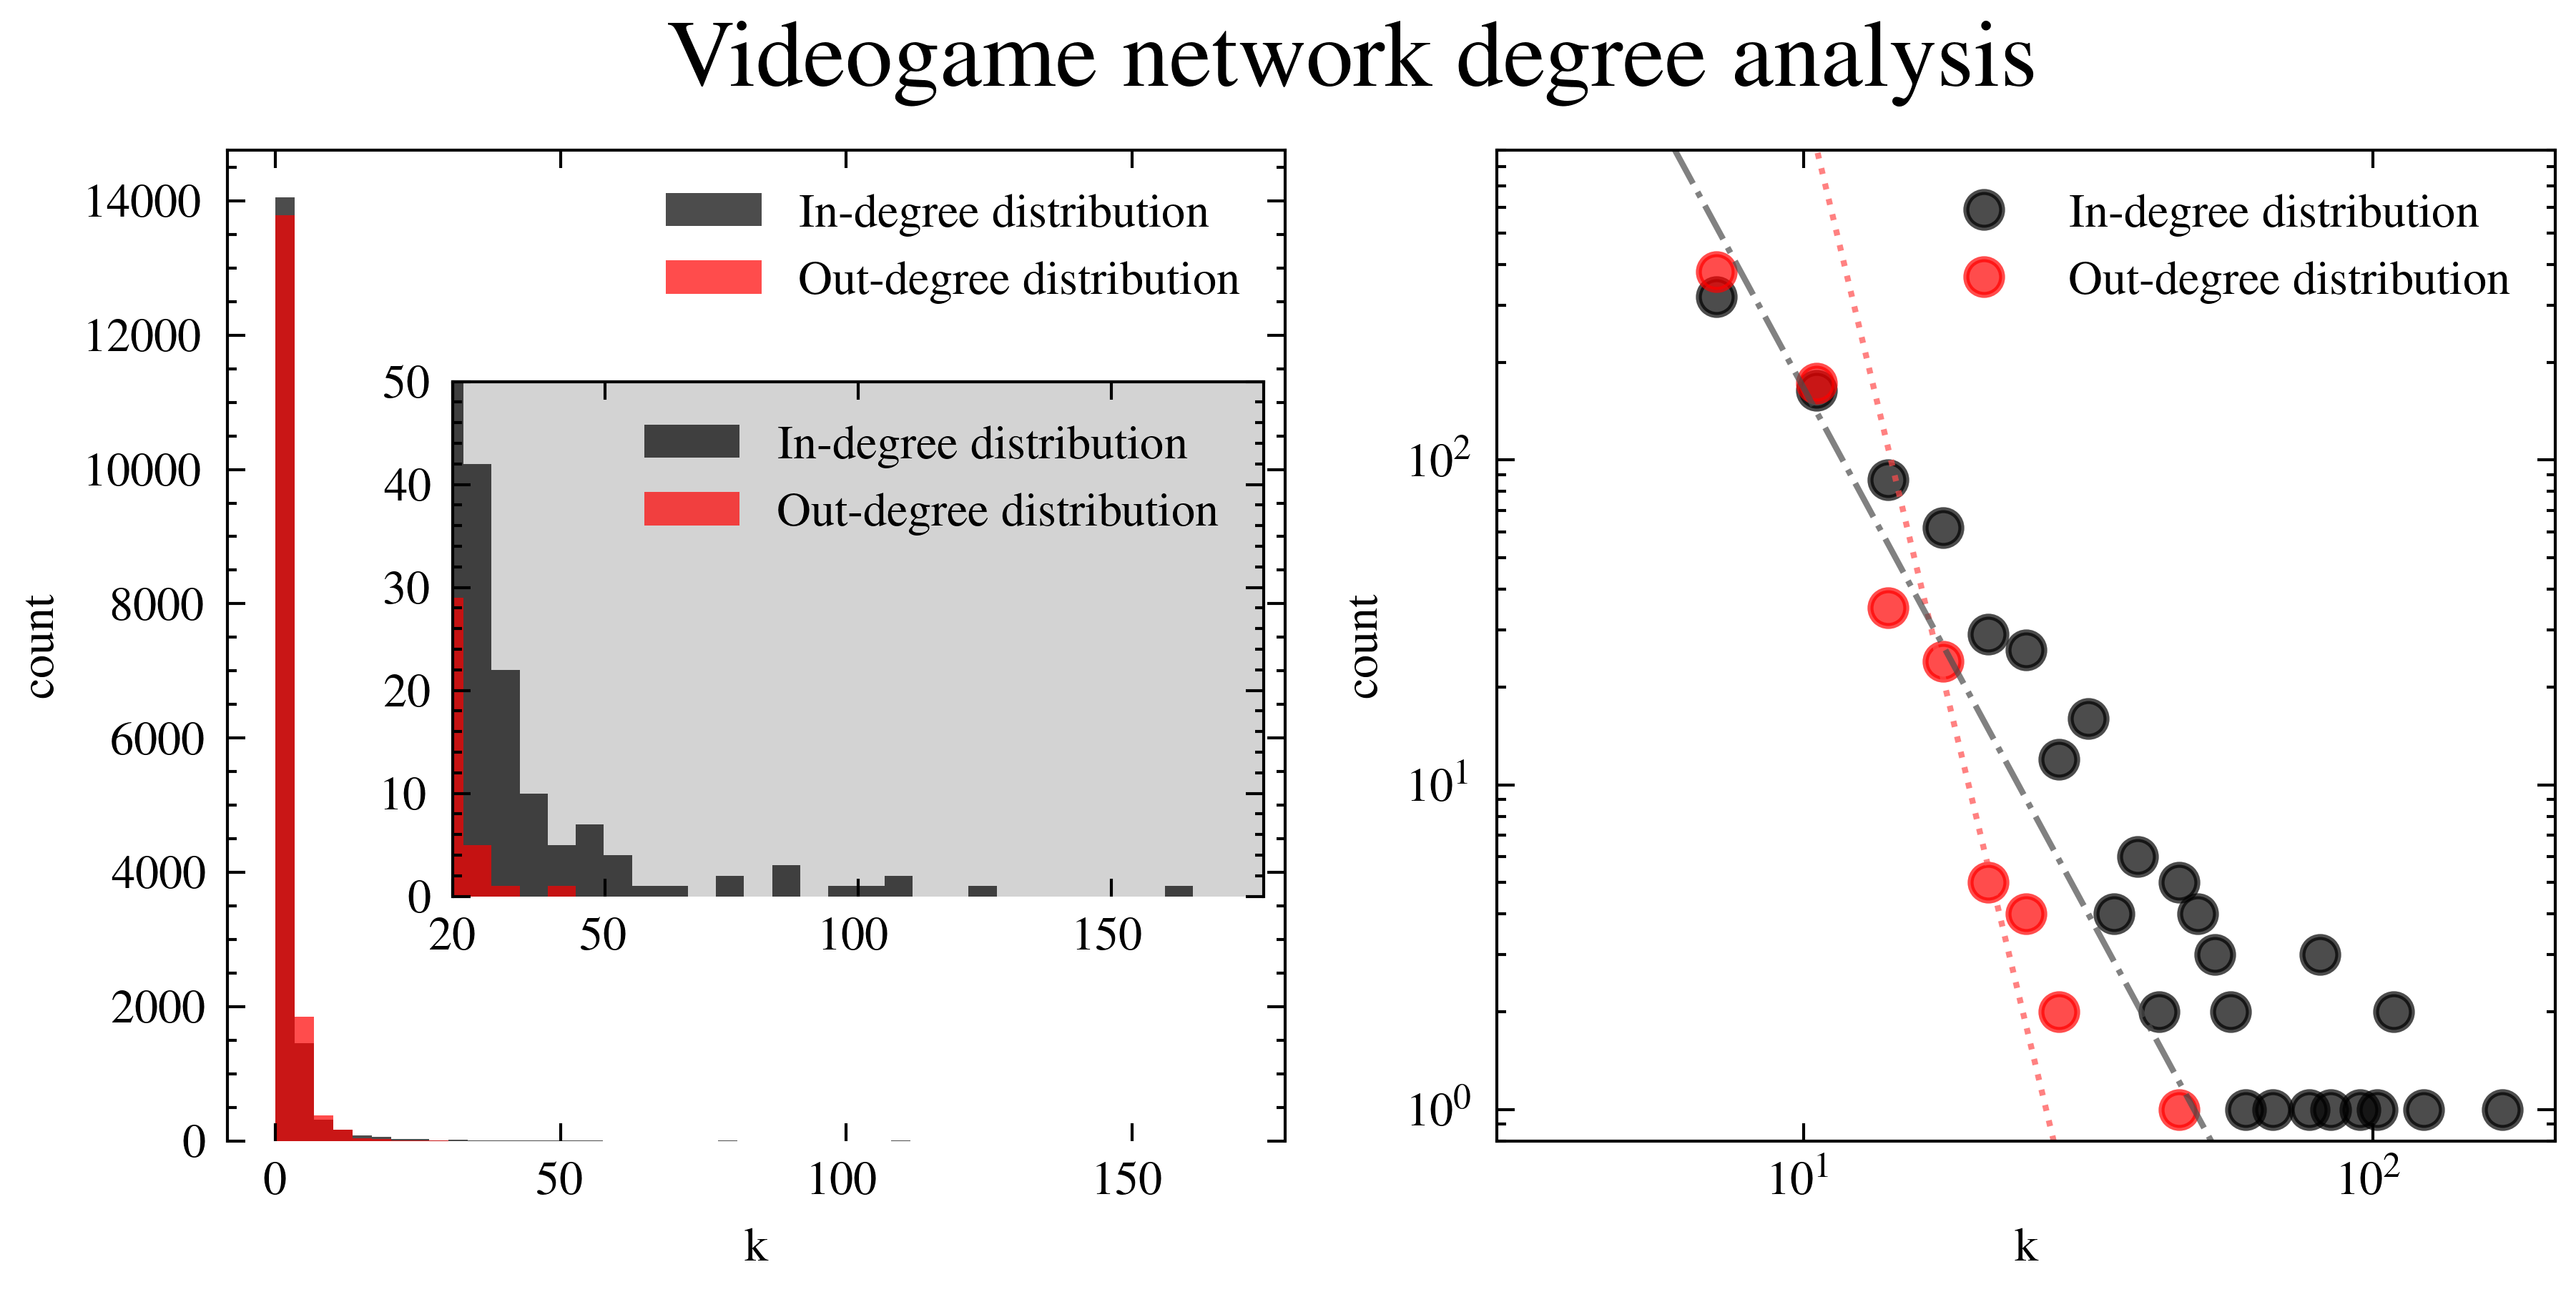

In [ ]:
plt.style.use(['science','ieee'])

fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_figwidth(7)
fig.set_figheight(3)
bins0 = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis', n_bins=50, fig = fig, ax=ax0
    , xscale="linear", yscale="linear"
    )

# cut = 40
# in_scatter = [d for d in dict(DIRECTED_G.in_degree).values() if d > cut]
# out_scatter = [d for d in dict(DIRECTED_G.out_degree).values() if d > cut]
# ax0.scatter(in_scatter, [0.5]*len(in_scatter), marker='+', color="#4c4c4c", alpha=0.7)
# ax0.scatter(out_scatter, [0.5]*len(out_scatter), marker='x', color="#ff4c4c", alpha=0.7)
# ax0.set_xlim(0, 25)


inset_ax = fig.add_axes([0.2, 0.3, 0.27, 0.4]) 
bins = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='', n_bins=30, fig = fig, ax=inset_ax
    , xscale="linear", yscale="linear"
    )
inset_ax.set_xlim(20,180)
inset_ax.set_ylim(0,50)
inset_ax.set_facecolor('lightgrey')
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.set_xticks([20,50,100,150])

# Compare each plot
bins2 = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis', n_bins=50,  fig = fig, ax=ax1
    , xscale="log", yscale="log"
    )

N = sum(dict(DIRECTED_G.in_degree).values())

def get_powerlaw(k, alpha):
    return N*(k**-alpha)

def f(x, y):
   return N*np.sin(x)
bins = bins[1:]
ax1.plot(bins, get_powerlaw(bins, out_alpha)*1000000, color="#ff4c4c", alpha=0.7)
ax1.plot(bins, get_powerlaw(bins, in_alpha)*10, color="#4c4c4c", alpha=0.7)
ax1.set_ylim(0.8,max(get_powerlaw(bins, out_alpha) + get_powerlaw(bins, in_alpha))*10)

## Centrality analysis

### Degree Centrality

In [ ]:
import networkx as nx
G = DIRECTED_G
top = 5
degree_centrality = nx.degree_centrality(G)
degree_most_central = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(degree_most_central)

[('Pac-Man', 0.013468634686346861), ('Super Mario Bros.', 0.008179581795817957), ('Street Fighter II', 0.008118081180811807), ('Super Smash Bros. Ultimate', 0.007933579335793356), ('Tetris', 0.007933579335793356)]


### Betweenness Centrality

In [ ]:
G = DIRECTED_G
top = 5
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_most_central = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(betweenness_most_central)

[('Pac-Man', 0.021422604591995423), ('Super Smash Bros. Ultimate', 0.01974309397207229), ('Street Fighter II', 0.01323156097580047), ('Minecraft', 0.01286370270332785), ('World of Warcraft', 0.00826647177898305)]


### Eigenvector Centrality

In [ ]:
import networkx as nx
G = DIRECTED_G
top = 5
eigenvector_centrality = nx.eigenvector_centrality(G)
eigenvector_most_central = sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(eigenvector_most_central)

[('Pac-Man', 0.5427187480961176), ('Galaxian', 0.31611910253300934), ('Galaga', 0.22215507578410007), ('Dig Dug', 0.22003739321118496), ('Rally-X', 0.20161017567644998)]


### Plotting Centrality

Group violence scores by degree of the node.

In [ ]:
violence_coefficients = {node: data["violence"] for node, data in nx.get_node_attributes(G, "sentiment").items()}
# Compute the degree of each node
degrees = dict(G.degree())

# Prepare data for plotting
degrees_list = []
violence_list = []

degree_violence = dict()

for node in G.nodes():
    degrees_list.append(degrees[node])
    violence_list.append(violence_coefficients.get(node, 0))  # Default to 0 if no violence coefficient

    if not degrees[node] in degree_violence:
        degree_violence[degrees[node]] = []
    degree_violence[degrees[node]] += [violence_coefficients.get(node, 0)]

In [ ]:
def draw_arrow_symbols(ax, symbols, x_coords, y_coords, xsize=0.1, ysize=0.1, color='k', lw=1):
    for symbol, x, y in zip(symbols, x_coords, y_coords):
        if symbol == '<':
            ax.plot([x-0.5*xsize, x + 0.5*xsize], [y, y + ysize], color=color, lw=lw, ls='solid')
            ax.plot([x-0.5*xsize, x + 0.5*xsize], [y, y - ysize], color=color, lw=lw, ls='solid')
        elif symbol == '>':
            ax.plot([x+0.5*xsize, x - 0.5*xsize], [y, y + ysize], color=color, lw=lw, ls='solid')
            ax.plot([x+0.5*xsize, x - 0.5*xsize], [y, y - ysize], color=color, lw=lw, ls='solid')


In [ ]:
import math
def boxplot_compare_two_values_with_bins(values_dict, num_bins, type_of_value, stat_method=stats.mannwhitneyu, fig=None, ax=None):
    # If no figure or axis is provided, create a new one
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 1)

    values = list(values_dict.values())
    # print(len(values))
    values = [math.log(val) if val != 0 else 0 for val in values ]
    # print(len(values))
    # Determine bin edges
    min_value, max_value = min(values), max(values)
    bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Group values into bins
    value_by_bin = [[] for _ in range(num_bins)]

    for node, value in zip(values_dict.keys(), values):
        coef = violence_coefficients.get(node, 0)
        for i in range(num_bins):
            if bin_edges[i] <= value < bin_edges[i+1]:
                value_by_bin[i].append(coef)
                break

    to_plot_indices = [i for i in range(num_bins) if len(value_by_bin[i]) != 0]
    # Create a boxplot
    flierprops = dict(marker='o', markerfacecolor='k', markersize=4, linestyle='none', alpha=0.5)

    boxplots = ax.boxplot([value_by_bin[i] for i in to_plot_indices], 
                        #   labels=[f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in to_plot_indices],
                        labels = to_plot_indices,
                          flierprops=flierprops)

    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(f'{type_of_value} Bins (Log)')
    ax.set_ylabel('Values')
    ax.set_title(f'{type_of_value}')
    ax.xaxis.set_minor_locator(plt.NullLocator())

    # Compare adjacent boxplots and mark significant differences
    num_boxes = len(boxplots['boxes'])
    y_max = max([max(data) for data in [value_by_bin [i] for i in to_plot_indices] if data])
    
    for i in range(num_boxes - 1):
        data1 = value_by_bin [to_plot_indices[i]]
        data2 = value_by_bin [to_plot_indices[i + 1]]

        # Perform statistical test (e.g., Mann-Whitney U test)
        if data1 and data2:  # Ensure both groups have data
            stat, p_value = stat_method(data1, data2)
            if p_value < 0.05:  # Using 0.05 as the threshold for significance
                
                m1 = np.median(data1)
                m2 = np.median(data2)
                symbol = "<" if m1 < m2 else ">"  # Unicode for '<' and '>'
                sep = 0.35
                x1, x2 = i + 1 + sep, i + 2 - sep
                y = (m1 + m2)*0.5
                
                ax.plot([x1, x2], [y, y], lw=1.5, c='k', ls=(0, (1, 1)))
                ysize = 0.02*y_max
                xsize = 0.1
                draw_arrow_symbols(ax, [symbol], [(x1 + x2) * 0.5], [y+ysize+ysize],xsize=xsize, ysize=ysize)

    return fig, ax


Boxplots in Figure 5.

(<Figure size 3600x3600 with 4 Axes>,
 <Axes: title={'center': 'Eigenvector Centrality'}, xlabel='Eigenvector Centrality Bins (Log)', ylabel='Values'>)

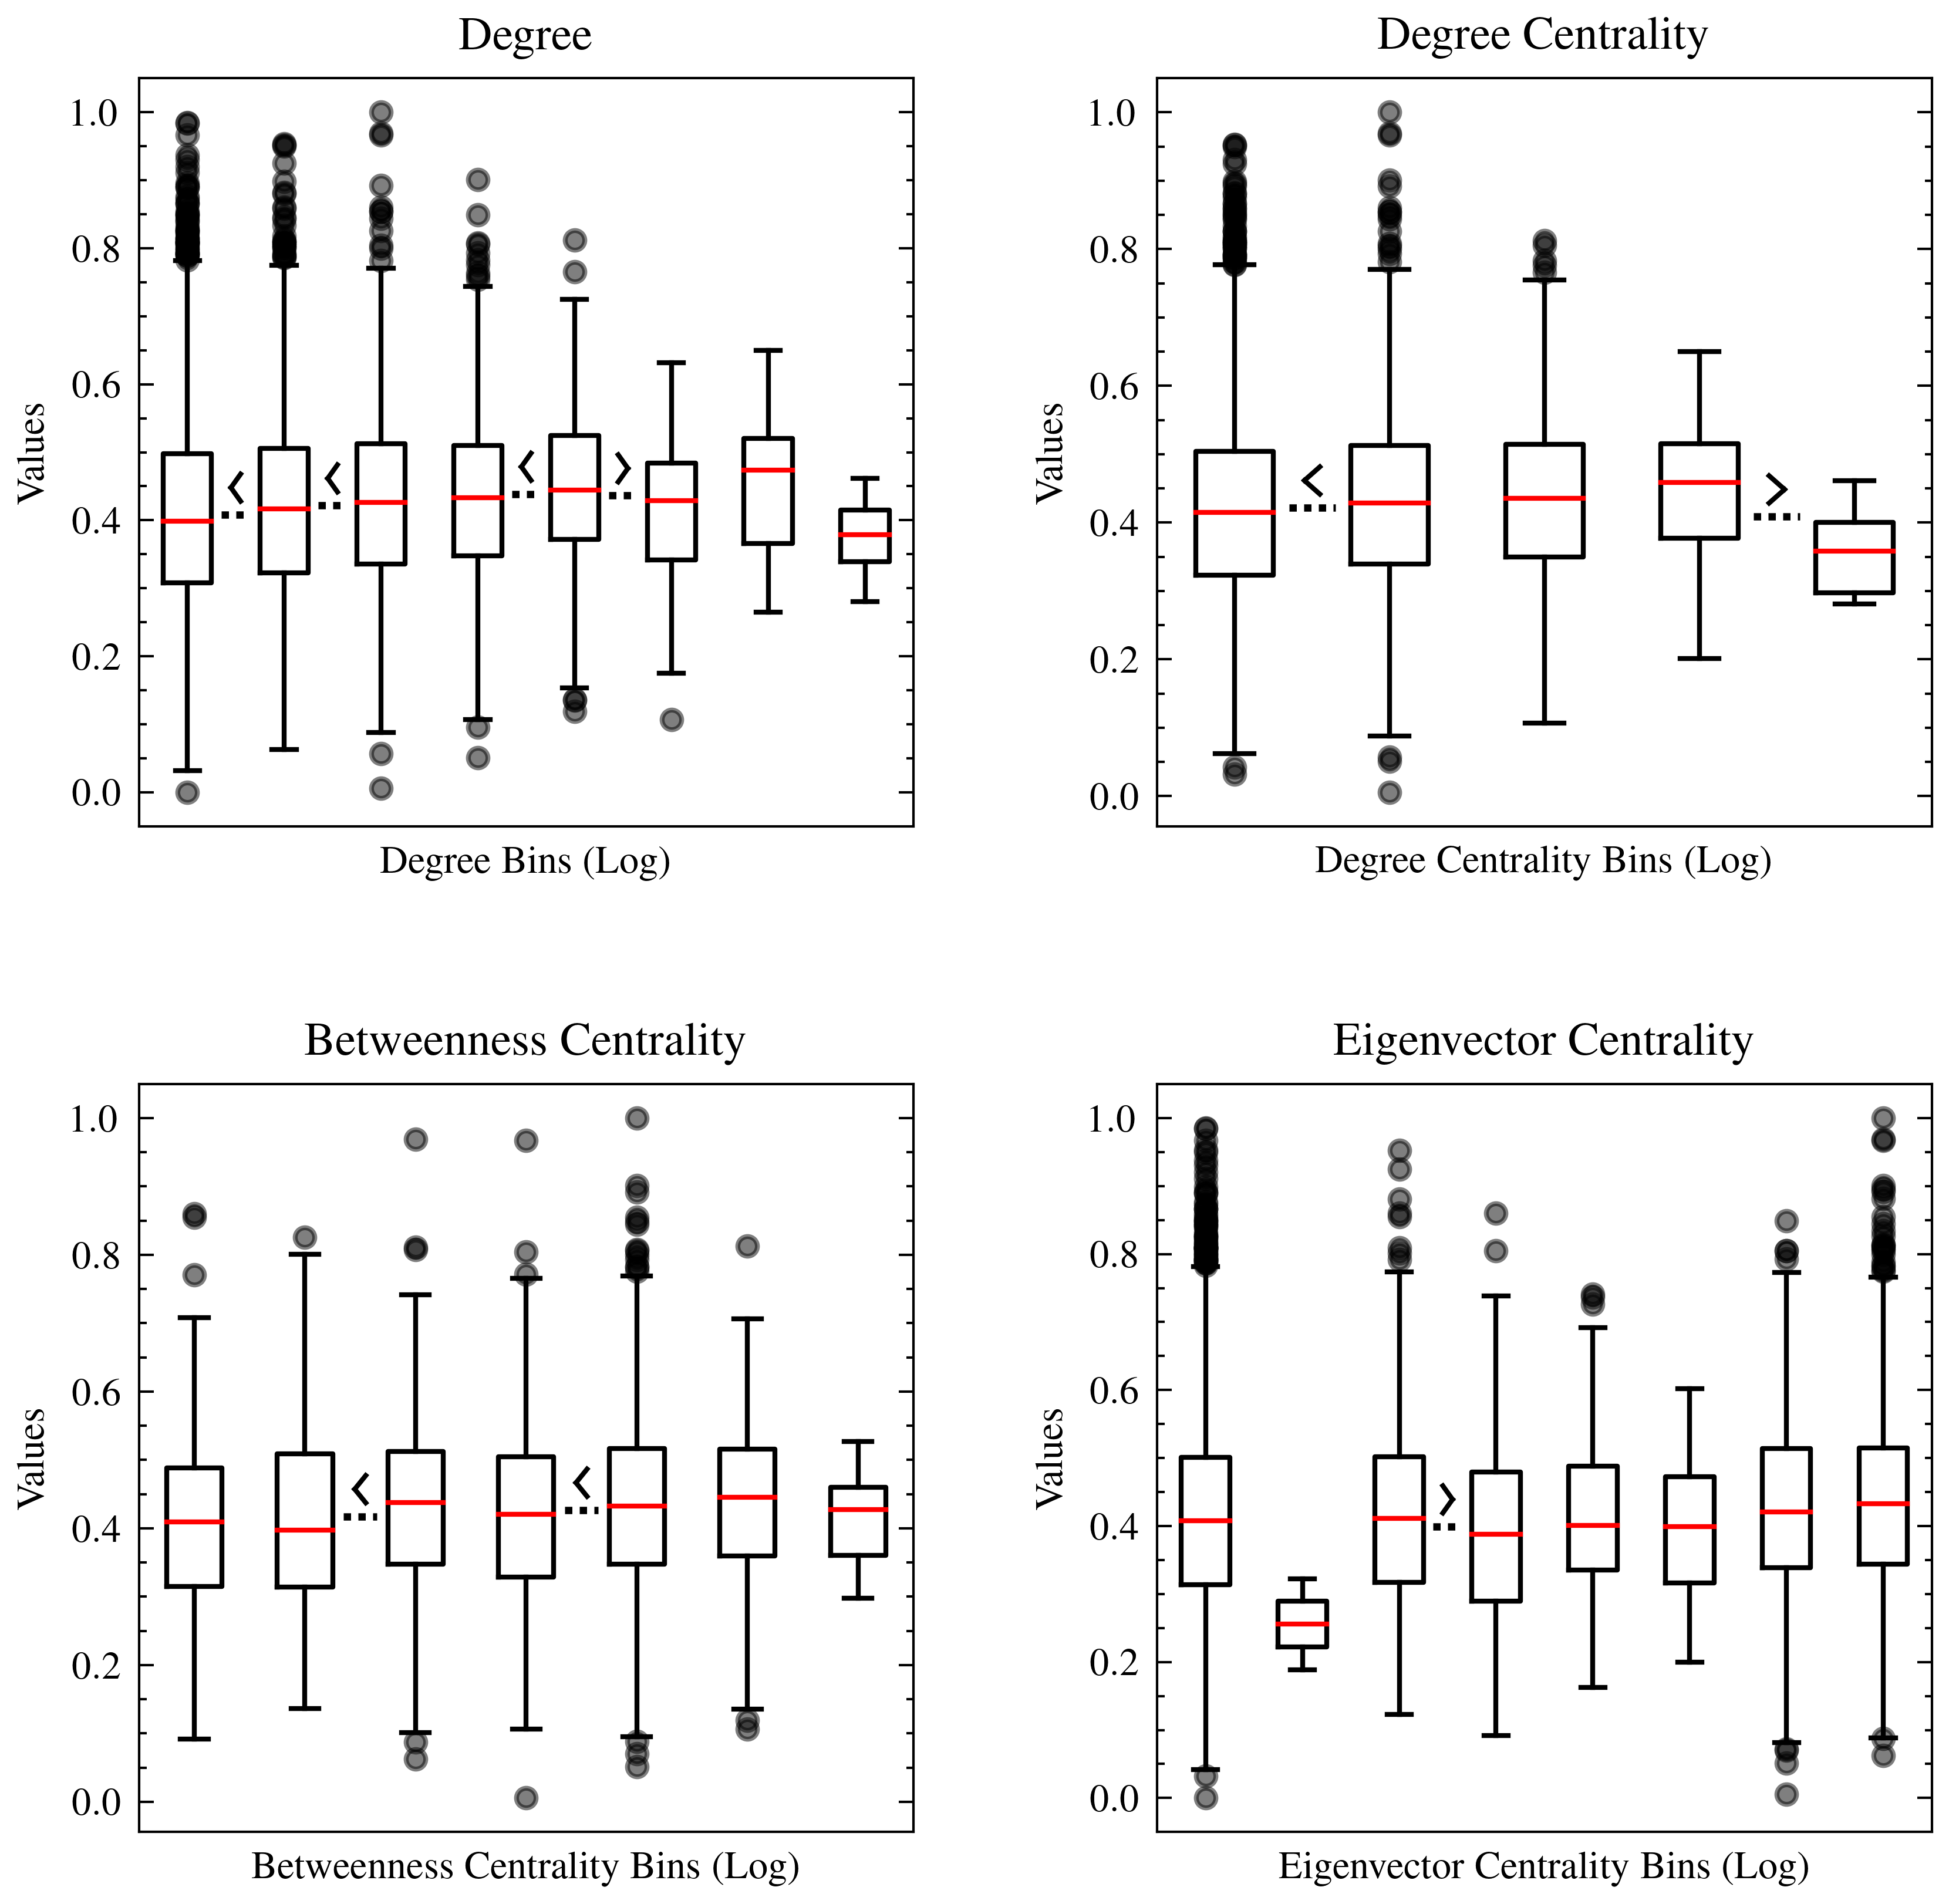

In [ ]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
fig, ([ax0, ax1], [ax2, ax3]) = plt.subplots(2,2 )
fig.tight_layout()
fig.set_figwidth(6)
fig.set_figheight(6)


# Compute the degree of each node
degrees = dict(G.degree())

percentile_partition = [10, 20, 30, 40, 50 ,60, 70, 80, 90, 100]
# fig.suptitle("Boxplots")
boxplot_compare_two_values_with_bins(degrees, 8, "Degree", fig=fig, ax=ax0)
boxplot_compare_two_values_with_bins(degree_centrality, 8, "Degree Centrality", fig=fig, ax=ax1)
boxplot_compare_two_values_with_bins(betweenness_centrality, 8, "Betweenness Centrality", fig=fig, ax=ax2)
boxplot_compare_two_values_with_bins(eigenvector_centrality, 8, "Eigenvector Centrality", fig=fig, ax=ax3)


### Compare with Kruskal (same results)

We tried to compare the same boxplot distributions with another statistic just to see if the result is the same. It is.

(<Figure size 3600x3600 with 4 Axes>,
 <Axes: title={'center': 'Values by Eigenvector Centrality Bins'}, xlabel='Eigenvector Centrality Bins (Log)', ylabel='Values'>)

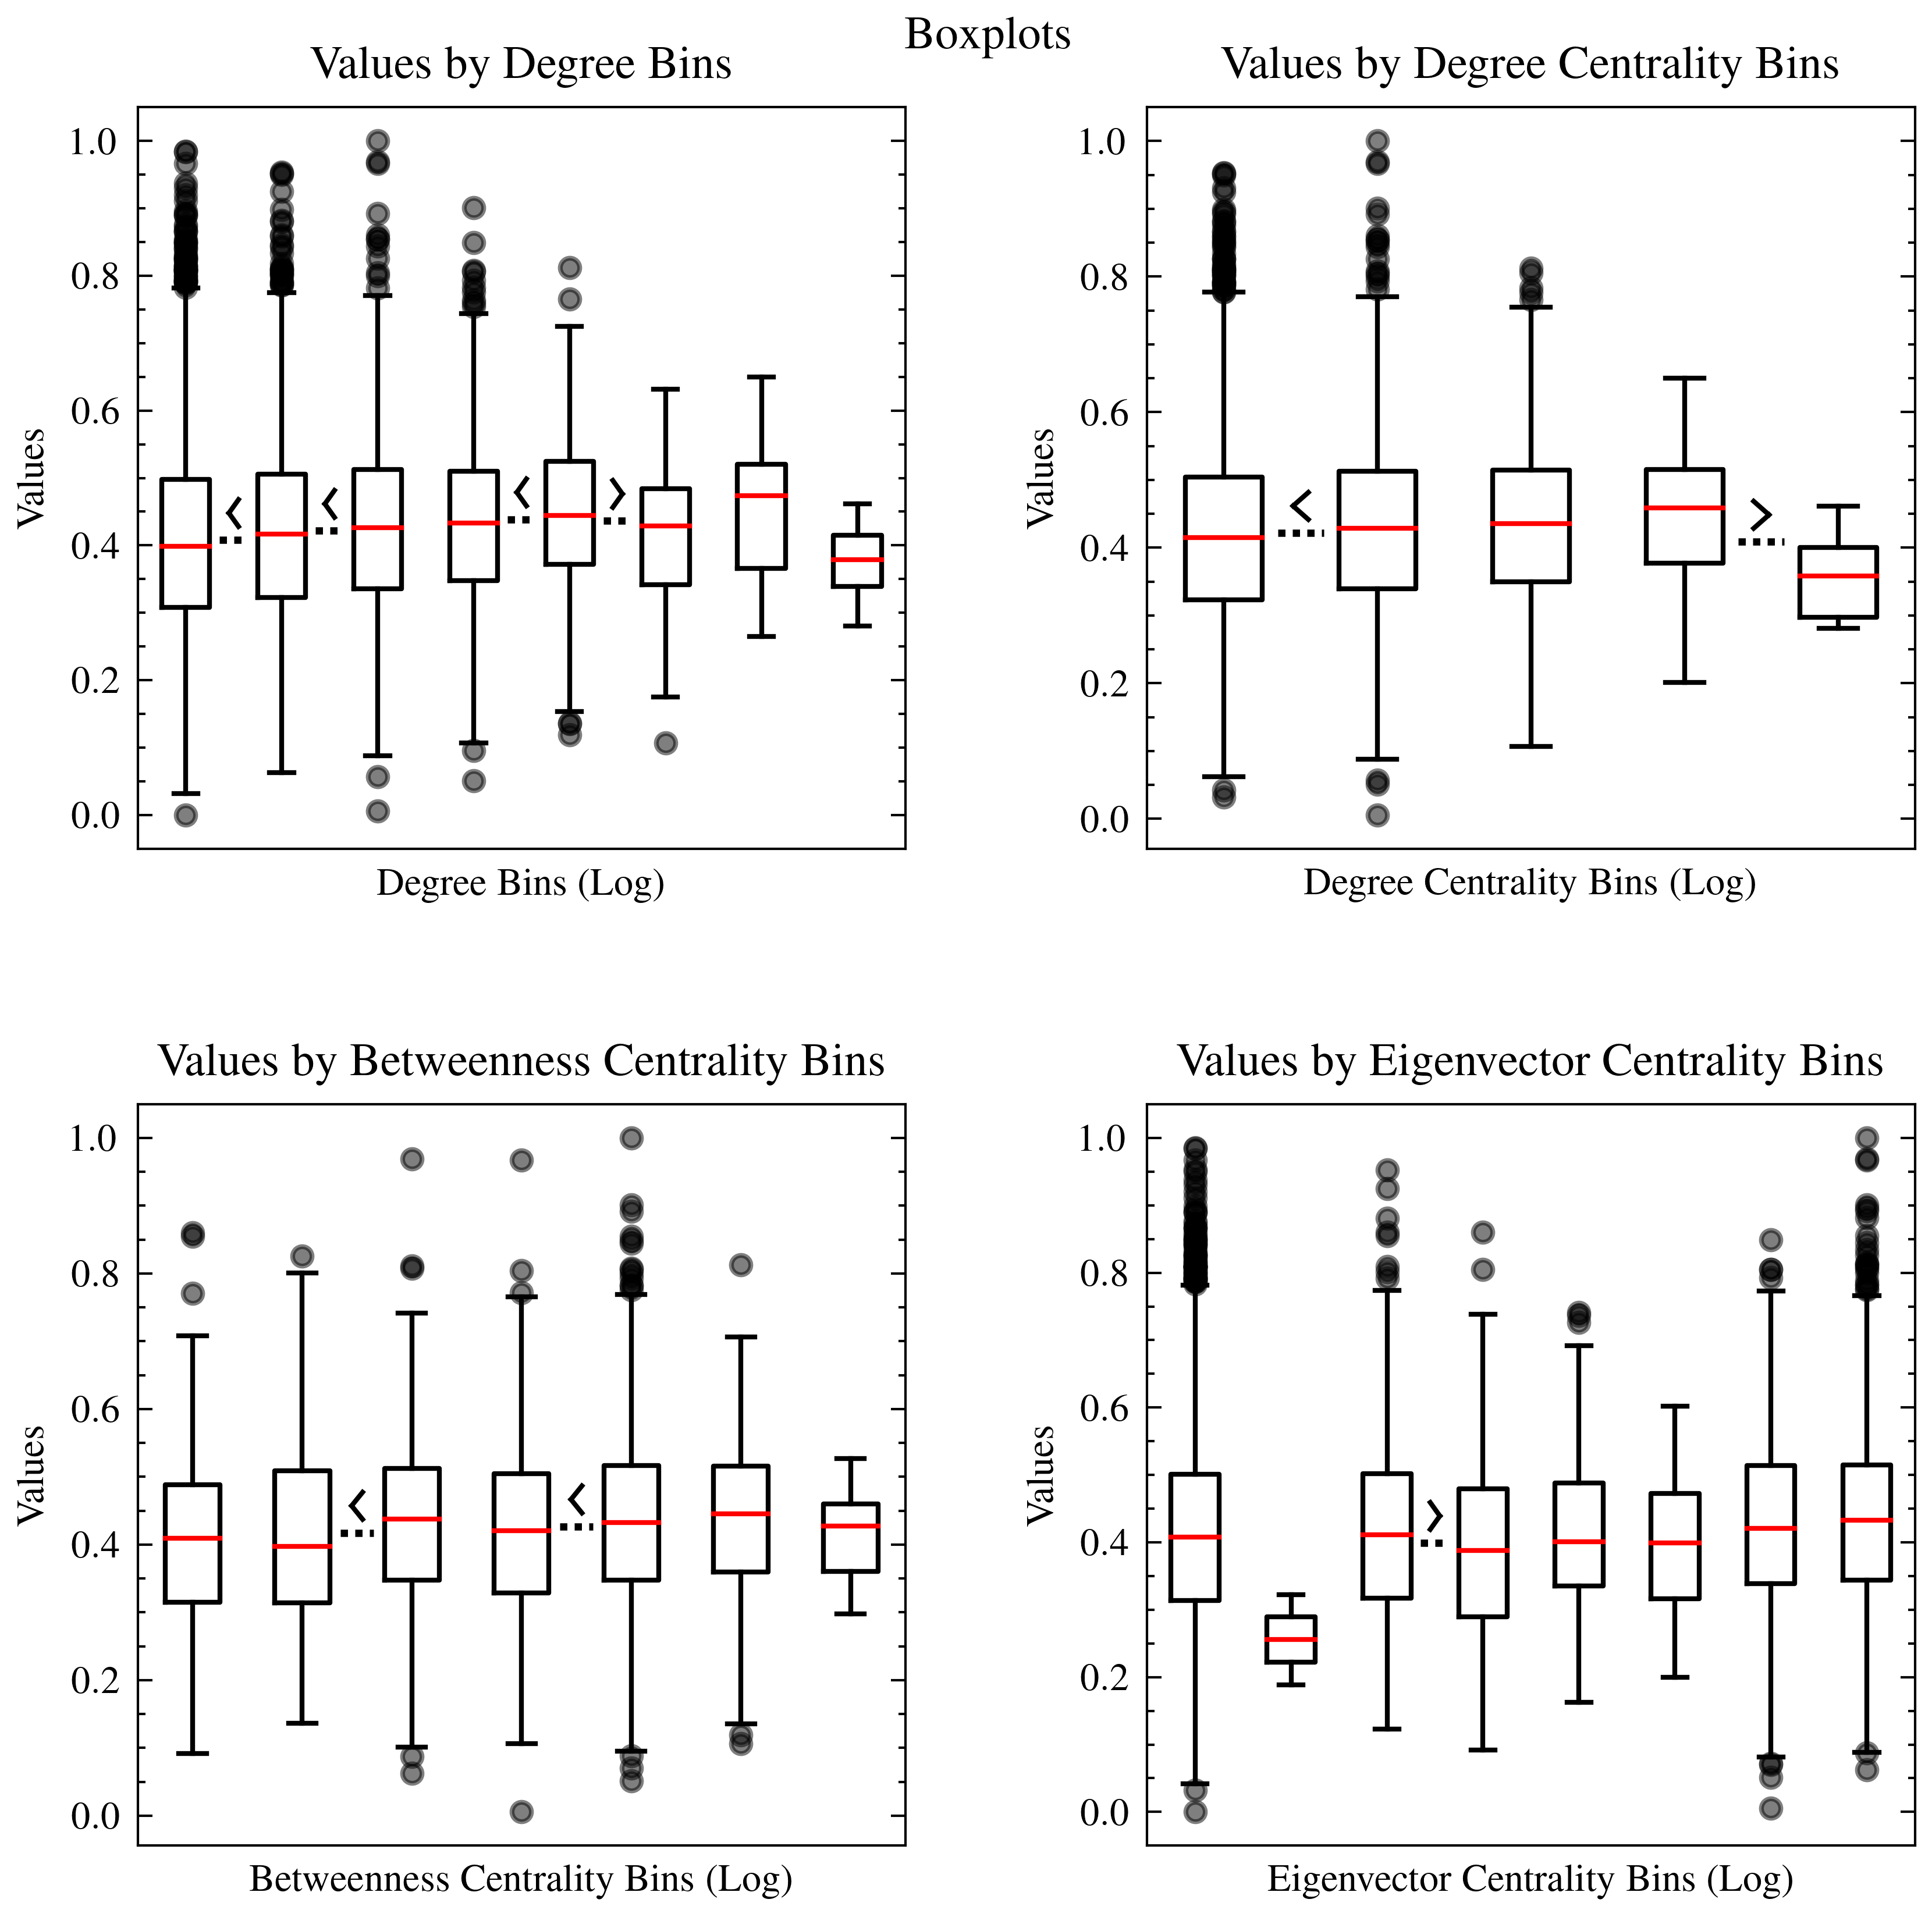

In [ ]:
fig, ([ax0, ax1], [ax2, ax3]) = plt.subplots(2,2 )
fig.tight_layout()
fig.set_figwidth(6)
fig.set_figheight(6)

# Compute the degree of each node
degrees = dict(G.degree())

percentile_partition = [10, 20, 30, 40, 50 ,60, 70, 80, 90, 100]
fig.suptitle("Boxplots")
boxplot_compare_two_values_with_bins(degrees, 8, "Degree", stat_method=stats.kruskal, fig=fig, ax=ax0)
boxplot_compare_two_values_with_bins(degree_centrality, 8, "Degree Centrality", stat_method=stats.kruskal, fig=fig, ax=ax1)
boxplot_compare_two_values_with_bins(betweenness_centrality, 8, "Betweenness Centrality", stat_method=stats.kruskal, fig=fig, ax=ax2)
boxplot_compare_two_values_with_bins(eigenvector_centrality, 8, "Eigenvector Centrality", stat_method=stats.kruskal, fig=fig, ax=ax3)

# Community Detection

Helper methods for specifically community detection parts

In [ ]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import community as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import json
import os

import pickle

# Load graph object from pickle file that we saved in lecture 4
DIRECTED_G = pickle.load(open('../data/graph.pickle', 'rb'))
UNDIRECTED_G = DIRECTED_G.copy().to_undirected()
# Prune the graph
UNDIRECTED_G = UNDIRECTED_G.subgraph(max(nx.connected_components(UNDIRECTED_G), key=len))

def plot_network(graph):
    # Visualize the graph with community colors
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)  # or use other layout algorithms like nx.kamada_kawai_layout
    nx.draw(graph, pos, 
            # node_color=[node_colors[node] for node in graph.nodes()], 
            edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
    plt.show()

## Louvain

Louvain partitions. The 'Ohters' community is every community with size < 1% put into one community.

In [ ]:
def others_communities(communities, others):
    # Initialize an empty set to store the combined community
    new_community = set()

    # Iterate through each index in the 'others' list
    for j in others:
        # Union operation: Combine the communities indexed by 'others'
        new_community = new_community.union(communities[j])

    # Filter out communities based on the 'others' list and add the combined community
    return [comm for i, comm in enumerate(communities) if i not in others] + [new_community]

In [ ]:
df = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities", "Node distribution", "Node distribution (%)", "Others (%)",
                           "Communities (with Others)","Initial modularity", "'Others' modularity"])

for i in range(10):
    # Apply the Louvain community detection algorithm
    resolution = 0 + (i*2)*0.1
    communities = louvain_communities(UNDIRECTED_G, resolution=resolution, seed=1234)
    communities = sorted([comm for comm in communities], key=len, reverse=True)
    len_communities = [len(comm) for comm in communities]
    percentages = [100*l/sum(len_communities) for l in len_communities]
    others = [i for i, el in enumerate(percentages) if el < 1]
    communities_others = others_communities(communities,  others)
    df.loc[len(df)] = {
        "Resolution": resolution,
        "# Communities": len(communities),
        "# Significant Communities": len([l/sum(percentages) for l in percentages if l > 1]),
        "Communities": communities,
        "Node distribution": len_communities,
        "Node distribution (%)": percentages,
        "Others (%)": sum([el for i, el in enumerate(percentages) if i in others]),
        "Communities (with Others)": communities_others,
        "Initial modularity": nx.community.modularity(UNDIRECTED_G, communities),
        "'Others' modularity": nx.community.modularity(UNDIRECTED_G, communities_others)
    }

In [ ]:
df.head(5)

,Resolution,# Communities,# Significant Communities,Communities,Node distribution,Node distribution (%),Others (%),Communities (with Others),Initial modularity,'Others' modularity
0,0.0,1,1,"[{Gauntlet Legends, Gunman Taco Truck, The Kin...",[10219],[100.0],0.000000,"[{Gauntlet Legends, Gunman Taco Truck, The Kin...",0.000000,0.000000
1,0.2,14,4,"[{Gunman Taco Truck, Half-Life 2: Episode Two,...","[5393, 2757, 1054, 724, 88, 54, 35, 29, 22, 19...","[52.77424405519131, 26.979156473236127, 10.314...",2.847637,"[{Gunman Taco Truck, Half-Life 2: Episode Two,...",0.542966,0.542530
2,0.4,20,12,"[{Gunman Taco Truck, Castlevania: Lords of Sha...","[2393, 1495, 1346, 846, 803, 695, 623, 579, 36...","[23.417164106076914, 14.62961150797534, 13.171...",2.886780,"[{Gunman Taco Truck, Castlevania: Lords of Sha...",0.726649,0.726162
3,0.6,29,17,"[{Castlevania: Lords of Shadow, Deathloop, Thi...","[1217, 1185, 847, 812, 764, 698, 640, 592, 564...","[11.909188766024073, 11.596046579900186, 8.288...",4.628633,"[{Castlevania: Lords of Shadow, Deathloop, Thi...",0.752621,0.751503
4,0.8,37,24,"[{Tarzan: Untamed, Xtreme Wheels, TimeSplitter...","[1099, 823, 759, 637, 625, 590, 559, 543, 485,...","[10.75447695469224, 8.053625599373715, 7.42734...",3.865349,"[{Tarzan: Untamed, Xtreme Wheels, TimeSplitter...",0.756568,0.755890


## Spectral Clustering

Just a try, it didnt work because it just grouped everything in one cluster.

In [ ]:
from sklearn.cluster import SpectralClustering
def spectral_clustering(graph, n_clusters = 10):
    # Convert the graph into an adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    # Perform spectral clustering
    # In practice, this should be based on the specific characteristics of the graph.
    spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral_cluster.fit_predict(adj_matrix)

    # Output the labels to see the community assignments
    return labels.tolist()

In [ ]:
import collections
labels = spectral_clustering(UNDIRECTED_G, 10)
collections.Counter(labels)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\PC-312\.conda\envs\sg_i\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC-312\.conda\envs\

Counter({0: 10119, 4: 10, 5: 6, 7: 17, 9: 6, 2: 14, 1: 6, 3: 25, 6: 5, 8: 11})

# Get Community Information

In [ ]:
def get_community_violence(community):
    # Filtering nodes present in the community from the graph UNDIRECTED_G
    nodes_in_community = (node for node in UNDIRECTED_G if node in community)
    
    # Retrieving sentiment attributes from the graph UNDIRECTED_G
    sentiments = nx.get_node_attributes(UNDIRECTED_G, "sentiment")

    # Extracting 'violence' attribute values for nodes within the community
    return [sentiments[node]['violence'] for node in nodes_in_community if node in sentiments]

from collections import Counter

def community_genre_analysis(community):
    # Filtering nodes present in the community from the graph UNDIRECTED_G
    nodes_in_community = [node for node in UNDIRECTED_G if node in community]
    
    # Retrieving 'genres' attribute values from the graph UNDIRECTED_G
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    
    # Filtering nodes in the community that have 'genres' attribute
    nodes_in_genre = [node for node in nodes_in_community if node in genres.keys()]
    
    # Flattening the genres for all nodes in the filtered community
    flatten_genres = [g for node in nodes_in_genre for g in genres[node]]
    
    # Counting the occurrence of each genre in the community
    counts = dict(Counter(flatten_genres))
    
    # Calculating the total number of genres in the community
    total = sum(counts.values())
    
    # Sorting the genres based on their counts in descending order
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    
    # Calculating the percentage of each genre in the community
    counts = [(i, 100 * c / total) for i, c in counts]
    
    return counts

def get_in_degree(community):
    return [DIRECTED_G.in_degree(node) for node in community]
def get_out_degree(community):
    return [DIRECTED_G.out_degree(node) for node in community]
def get_degree(community):
    return [UNDIRECTED_G.degree(node) for node in community]

years = nx.get_node_attributes(UNDIRECTED_G, "year")

info = dict()
info["sentiment"] = {i: np.average(get_community_violence(comm)) for i,comm in enumerate(communities)}
info["sentiment_more"] = {i: get_community_violence(comm) for i,comm in enumerate(communities)}
info["year"] = {i: np.average([years[el] for el in comm if el in years]) for i,comm in enumerate(communities)}
info["year_more"] = {i: [years[el] for el in comm if el in years] for i,comm in enumerate(communities)}
info["genre"] = {i: community_genre_analysis(comm)  for i,comm in enumerate(communities)}
info["in_degree"] = {i: get_in_degree(comm)  for i,comm in enumerate(communities)}
info["out_degree"] = {i: get_out_degree(comm)  for i,comm in enumerate(communities)}

sorted_communities_by_year_indexes = [str(i) for i,_ in sorted(list(info["year"].items()), key=lambda x: x[1])]

def boxplot_communities(y,x, title, yscale = None):
    fig, ax = plt.subplots(figsize=(10,6))
    # Create a boxplot
    ax.boxplot(y, labels=x)

    # Add titles and labels
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.set_xlabel('Categories')
    if yscale != None:
        ax.set_yscale('log')
    # Show the plot
    fig.show()

## Year analysis

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["year"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average year in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["year_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by year')

In [ ]:
from scipy import stats
#   Perform the Kruskal-Wallis H Test
def kruskal_wallis_test(*groups):
    stat, p_value = stats.kruskal(*groups)
    return stat, p_value

iter_list = [int(i) for i in sorted_communities_by_year_indexes]
results = pd.DataFrame(columns=['index'] + iter_list)
threshold = 0.05
for k, i in enumerate(iter_list):
    iteration = dict()
    iteration["index"] = i
    # for j in iter_list[0: (k+1)]:
    #     iteration[j] = "-"
    for j in iter_list[(k+1):len(iter_list)]:
        (stat, p_value) = kruskal_wallis_test(info['in_degree'][i], info['in_degree'][j])
        iteration[j] = "+" if p_value < threshold else " "
    results.loc[len(results)] = iteration

results

## By in-degree

In [ ]:
import math

y = [[d for d in info["in_degree"][int(i)]] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by In-degree')

## By Violence

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["sentiment"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average Violence in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["sentiment_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by violence')

## By Genre

In [ ]:
def genre_analysis():
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    nodes_in_genre = [node for node in UNDIRECTED_G if node in genres.keys()]
    flatten_genres = [g  for node in nodes_in_genre for g in genres[node]]
    counts = dict(Counter(flatten_genres))
    # total = sum(counts.values())
    total = len(nodes_in_genre)
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    counts = [(i, 100*c/total) for i,c in counts]
    return counts, len(nodes_in_genre)
overall_prop, total_games_with_genre = genre_analysis()

In [ ]:
from scipy.stats import chi2_contingency

def check_significant_overrepresentation(overall_proportions, community_proportions, total_games):
    significant_genres = []
    # total_games_in_community = sum(c for _,c in overall_proportions)
    for genre, comm_prop in community_proportions:
        overall_prop = next((item[1] for item in overall_proportions if item[0] == genre), None)
        if overall_prop is None:
            continue  # Skip if genre is not found in overall proportions

        # Calculate expected and observed counts
        expected_count = overall_prop * total_games / 100
        observed_count = comm_prop * total_games / 100
        contingency_table = np.array([[observed_count, total_games - observed_count],
                                      [expected_count, total_games - expected_count]])

        # Perform the chi-squared test
        chi2, p_value = chi2_contingency(contingency_table)[:2]

        if p_value < 0.05:  # Consider significance level of 0.05
            if observed_count > expected_count:
                representation = '+++ Overrepresented +++'
            else:
                representation = '--- Underrepresented ---'
            significant_genres.append((genre, comm_prop, 100*(observed_count/expected_count-1), representation))

    return sorted(significant_genres, key=lambda x: x[2], reverse=True)

In [ ]:
genre_breakdown = pd.DataFrame(columns=["Community", "Genre", "Presence (%)", "Increase (%)", "Status"])
genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
max_genre_length = max(len(g) for g in genres)
total = 0
for i in range(len(communities)):
    for (g,c,v,r) in significant_genres:
        print(f"\t\t{g.ljust(max_genre_length)}{round(c,2)}%\t{round(v,2)}%\t{r}")
        total += c
        genre_breakdown.loc[len(genre_breakdown)] = {
            "Community": i,
            "Genre": g, 
            "Presence (%)": round(c,2),
            "Increase (%)": round(v,2),
            "Status": r
        }
    

## Community descriptions

As the data was categoried into different communities by sentiment, the following descriptions are what ChatGPT considered each category to represent. These descriptions are supplementary, just for visualization of possible reasons for the communities - they were not used in data analysis itself.

#### Community 0
- **Overrepresented Genres:** Immersive sims, Survival horror video games, Stealth video games, Soulslike video games, Psychological horror games, Neo-noir video games, Open-world video games, Action-adventure games, Survival video games, Art games, Sandbox games, Hack and slash games, Mystery video games, Horror video games, Beat 'em ups, Adventure games.
    - A strong preference for narrative-driven, immersive experiences with a focus on horror, stealth, and open-world adventure.

#### Community 1
- **Overrepresented Genres:** Dress-up video games, Party video games, Educational video games, Pinball video games, Metroidvania games, Puzzle video games, Racing video games, Platformers, Action games, Action-adventure games, Shooter games, Simulation video games, Tactical role-playing video games, Art games, Hack and slash games.
    - Diverse interests ranging from creative and social games like Dress-up and Party games to more action-oriented genres like Racing and Shooter games.

#### Community 2
- **Overrepresented Genres:** Quiz video games, Shooter games, Interactive movie video games, Pinball video games, Educational video games, Racing video games, Action games, Platformers, Puzzle video games, Sports video games, Art games, Party video games, Metroidvania games.
    - A mix of intellectual and interactive genres, suggesting a community that enjoys both knowledge-based challenges and dynamic action games.

#### Community 3
- **Overrepresented Genres:** Social deduction video games, Battle royale games, Roguelike video games, Sandbox games, Construction and management simulation games, Non-games, Survival video games, Vehicle-building video games, Pinball video games, Strategy video games, Neo-noir video games, Simulation video games, Shooter games, Music video games, Metroidvania games, Art games, Open-world video games, Puzzle video games, Action games, Hack and slash games, Beat 'em ups, Stealth video games, Platformers.
    - A highly eclectic mix, indicating a community with varied tastes in gaming, from strategy and simulation to fast-paced action and survival genres.

#### Community 4
- **Overrepresented Genres:** Incremental games, Tactical role-playing video games, Role-playing video games, Mystery video games, Digital tabletop games, Roguelike video games, Simulation video games, Music video games.
    - Shows a preference for gradual progression in Incremental games, strategic depth in Tactical RPGs, and a blend of mystery and music themes.

#### Community 5
- **Overrepresented Genres:** Fighting games, Martial arts video games, Sports video games, Beat 'em ups, Digital tabletop games, Educational video games, Soulslike video games, Hack and slash games, Action games, Platformers, Shooter games, Action-adventure games.
    - Focuses on physical and competitive gaming experiences, with an emphasis on fighting, sports, and action-packed genres.

#### Community 6
- **Overrepresented Genres:** Puzzle video games, Shooter games, Action games, Platformers, Action-adventure games, Beat 'em ups, Racing video games, Party video games, Art games, Metroidvania games.
    - A blend of fast-paced action (Shooter, Beat 'em ups) and thoughtful gameplay (Puzzle, Metroidvania), indicating versatile gaming interests.

#### Community 7
- **Overrepresented Genres:** Soulslike video games, Horror video games, Stealth video games, Shooter games, Psychological horror games, Sandbox games, Action-adventure games, Art games, Open-world video games, Mystery video games, Neo-noir video games, Tactical role-playing video games, Hack and slash games, Beat 'em ups, Fighting games.
    - A strong inclination towards intense and immersive experiences, particularly in the realms of horror, stealth, and action.

#### Community 8
- **Overrepresented Genres:** Racing video games, Vehicle-building video games, Simulation video games, Sandbox games, Open-world video games, Shooter games, Horror video games, Beat 'em ups, Tactical role-playing video games, Action games, Fighting games, Action-adventure games, Stealth video games, Art games, Adventure games.
    - Enjoys a mix of high-speed Racing, in-depth Simulation, and engaging Open-world adventures, along with action-packed Shooter and Fighting games.

#### Community 9
- **Overrepresented Genres:** Shooter games, Fighting games, Stealth video games, Racing video games, Beat 'em ups, Action games, Art games, Mystery video games, Hack and slash games, Action-adventure games, Psychological horror games, Horror video games, Tactical role-playing video games.
    - Prefers action and adventure with a blend of Shooter, Fighting, and Stealth games, complemented by Horror and Mystery genres for narrative depth.

#### Community 10
- **Overrepresented Genres:** Music video games, Puzzle video games, Shooter games, Racing video games, Beat 'em ups, Art games, Action games, Hack and slash games, Platformers, Fighting games, Action-adventure games.
    - Shows a balance between rhythm-based Music games and high-energy genres like Racing and Shooter games, with a touch of Puzzle and Platformer elements.

#### Community 11
- **Overrepresented Genres:** Role-playing video games, Simulation video games, Incremental games, Construction and management simulation games, Tactical role-playing video games, Sandbox games, Open-world video games, Strategy video games, Immersive sims, Adventure games.
    - A preference for complex and strategic gaming experiences in RPGs and Simulation genres, indicating a taste for depth and narrative.

#### Community 12
- **Overrepresented Genres:** Non-games, Digital tabletop games, Typing video games, Educational video games, Metroidvania games, Platformers, Action games, Strategy video games, Tactical role-playing video games, Hack and slash games.
    - Enjoys a variety of genres from educational and strategy-based games to more dynamic action-oriented experiences.

#### Community 13
- **Overrepresented Genres:** Eroge, Typing video games, Construction and management simulation games, Music video games, Hack and slash games, Tactical role-playing video games, Mystery video games, Beat 'em ups, Shooter games, Fighting games, Role-playing video games.
    - Diverse interests with a mix of adult-themed Eroge, rhythm-based Music games, and a range of action-packed genres like Hack and slash, and Shooter games.

#### Community 14
- **Overrepresented Genres:** Racing video games, Open-world video games, Martial arts video games, Simulation video games, Metroidvania games, Beat 'em ups.
    - A strong preference for dynamic and immersive experiences, particularly in Racing and Open-world games, with an interest in combat-oriented genres.

#### Community 15
- **Overrepresented Genres:** Incremental games, Interactive movie video games, Puzzle video games, Strategy video games, Simulation video games, Shooter games, Art games, Music video games, Action games, Role-playing video games, Open-world video games, Hack and slash games.
    - Enjoys a combination of thought-provoking Strategy and Simulation games with more action-focused Shooter and Hack and slash genres.

#### Community 16
- **Overrepresented Genres:** Music video games, Puzzle video games, Racing video games, Party video games, Fighting games.
    - A blend of rhythm and strategy with Music and Puzzle games, alongside fast-paced Racing and Fighting games for a dynamic gaming experience.

#### Community 17
- **Overrepresented Genres:** Non-games, Music video games, Sandbox games, Party video games, Tactical role-playing video games, Action games, Puzzle video games, Sports video games, Action-adventure games, Hack and slash games, Horror video games, Beat 'em ups, Open-world video games.
    - A diverse range of interests from rhythm and strategy in Music and Puzzle games to action-oriented genres like Sports, Action-adventure, and Hack and slash games.
